In [1]:
import io
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import requests
from art.estimators.classification import BlackBoxClassifier, BlackBoxClassifierNeuralNetwork, PyTorchClassifier
from art.attacks.evasion import HopSkipJump, SquareAttack, SimBA, FastGradientMethod
from art.utils import to_categorical
from azureml.core import Workspace

from aidefender.utils.data import load_cats_and_dogs
from aidefender.utils.aml import mount_model
from aidefender.utils.pytorch import load_model, create_art_classifier

In [2]:
# data_path = '../artifacts/data/cats_dogs/'
data_path = '/datadrive/aidefender/data/cats_dogs/'
cat_sample_id = 8
dog_sample_id = -4
labels_dict = {0: 'cat', 1: 'dog'}

# Load data

In [3]:
images, labels = load_cats_and_dogs(data_path)

In [4]:
images.shape

(1800, 224, 224, 3)

In [5]:
image_cat = images[cat_sample_id]
image_dog = images[dog_sample_id]

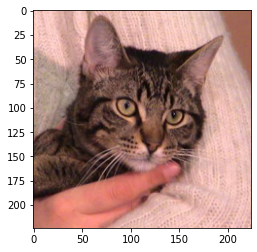

In [6]:
plt.imshow(image_cat)

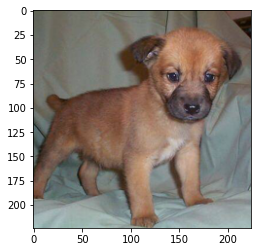

In [7]:
plt.imshow(image_dog)

# Predict using the deployed model

In [8]:
aml_model_name = 'cats_and_dogs'
service_url = 'http://196bdccd-15c2-4e99-93a2-c8cb3387a73c.eastus.azurecontainer.io/score'
service_defended_url = 'http://f016b8e5-61ba-42d8-848b-d83798ac602f.eastus.azurecontainer.io/score'

In [9]:
def get_image_bytes(image):
    file_stream = io.BytesIO()
    
    img = Image.fromarray(image.astype(np.uint8))
    img.save(file_stream, format='png')
    image_bytes = file_stream.getvalue()
    
    return image_bytes

In [10]:
def predict(service_url, image):
    image_bytes = get_image_bytes(image)
    
    files = {'image': image_bytes}
    r = requests.post(service_url, files=files)    
    
    response = r.json()
    
    return response

In [11]:
def predict_batch(service_url, images):
    labels = ['cat', 'dog']
    
    predictions = [
        predict(service_url, img)
        for img in images
    ]
    predictions = np.array([[pred[label] for label in labels] for pred in predictions], dtype=np.float32)
    
    return predictions

In [12]:
predict(service_url, image_cat)

{'cat': 0.9999990463256836, 'dog': 9.633325817048899e-07}

In [13]:
predict(service_url, image_dog)

{'cat': 1.5945294080665917e-06, 'dog': 0.9999984502792358}

In [14]:
predict_batch(service_url, [image_cat, image_dog])

array([[9.9999905e-01, 9.6333258e-07],
       [1.5945294e-06, 9.9999845e-01]], dtype=float32)

# Generate adversarial examples

In [15]:
sample_idx = 8

In [16]:
target_image = images[sample_idx].astype(np.float32)

In [17]:
# ws = Workspace(
#     subscription_id="9e7c2d63-bc69-4abc-a8c4-7b90cf90b7de",
#     resource_group="rgpmaidapaidefender",
#     workspace_name="aidefenderaml",
# )

In [18]:
# with mount_model(ws, aml_model_name) as model_path:
#     model = load_model(model_path)

In [19]:
# classifier = create_art_classifier(model)

In [20]:
# attack = FastGradientMethod(classifier, norm=2, eps=200, eps_step=0.1)

In [21]:
# images_adv = attack.generate([target_image])

In [22]:
# images_adv.shape

In [23]:
# classifier.predict(images_adv)

In [24]:
classifier = BlackBoxClassifierNeuralNetwork(
    lambda x: predict_batch(service_url, x), (224, 224, 3), 2, channels_first=False, clip_values=(0, 255)
)

In [25]:
attack = SquareAttack(estimator=classifier, norm="inf", max_iter=5000, eps=10, p_init=0.8, nb_restarts=5)

In [26]:
images_adv = attack.generate([target_image])

SquareAttack - restarts:   0%|          | 0/5 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

In [27]:
image = images[sample_idx]
image_adv = images_adv[0].astype(np.uint8)

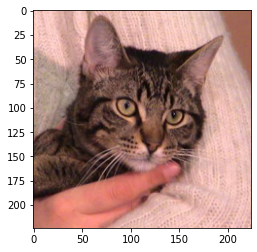

In [28]:
plt.imshow(image)

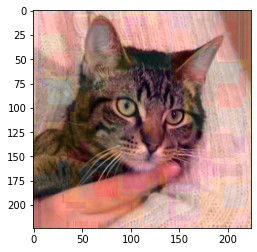

In [34]:
plt.imshow(image_adv)

## Test the service

In [35]:
predict(service_url, image)

{'cat': 0.9999990463256836, 'dog': 9.633325817048899e-07}

In [36]:
predict(service_url, image_adv)

{'cat': 0.49894213676452637, 'dog': 0.5010578036308289}

In [37]:
predict(service_defended_url, image_adv)

{'label': 0}

In [38]:
Image.fromarray(image).save('/datadrive/aidefender/images/cat.png')
Image.fromarray(image_adv).save('/datadrive/aidefender/images/cat_adv.png')
Image.fromarray(image_dog).save('/datadrive/aidefender/images/dog.png')